<a href="https://colab.research.google.com/github/sindhu819/Projects/blob/master/Copy_of_Group1_Milestone1_CIFAR_100_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification - CIFAR 100
##Group 1
### Super Class : Household Electronics, Household Furniture

<font color='blue'>Import all the required libraries.</font>

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [0]:
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz

In [0]:
!tar xf spark-2.4.4-bin-hadoop2.7.tgz


In [0]:
!pip install -q findspark

In [0]:
import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7")# SPARK_HOME

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.sql.types import *


from pyspark.sql import Row

from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

import folium
import html

import keras
from keras.datasets import cifar100

Using TensorFlow backend.


<font color = 'blue'>Initialize spark session with required memory for executor and driver.</font>

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("CIFAR") \
    .config("spark.executor.memory", "10g") \
    .config("spark.driver.memory", "10g") \
    .getOrCreate()

In [0]:
spark_home = os.environ.get('SPARK_HOME', None)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


<font color='blue'>Mount the google drive to download files and create pydrive and the required data files in pydrive.</font>

In [0]:
#1 Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#2. Get the file
#make sure you upload all your data files to your Google drive and change share->Advanced->change->anyone with the link can view

downloaded1 = drive.CreateFile({'id':'1T6FAL8Gn_k7qEexv7yzuOgYoJNqjOX8U'}) # replace the id with id of file you want to access
downloaded1.GetContentFile('train')
downloaded2 = drive.CreateFile({'id':'1T932ddFaS0sJHWXOO1hLicbAp0W04eY6'}) # replace the id with id of file you want to access
downloaded2.GetContentFile('test')
downloaded3 = drive.CreateFile({'id':'1pZ_buxDxG0DKT69zszNGySt_hGSbT0Oi'}) # replace the id with id of file you want to access
downloaded3.GetContentFile('meta')

<font color='blue'>Unpickle all the pickle files. Data is available in different files, train, test. Metadata is available in meta file. </font>

In [0]:
#unpickle the file
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dic = pickle.load(fo, encoding='bytes')
    return dic
# train data
datatrain = unpickle('train')
# test data
datatest = unpickle('test')
# meta data
datameta = unpickle("meta")

#convert the data type from byte to utf-8
fine_labels = [x.decode('utf-8')for x in datameta.get(b'fine_label_names')]
print(fine_labels)
coarse_labels = [x.decode('utf-8')for x in datameta.get(b'coarse_label_names')]
print(coarse_labels)


['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

<font color='blue'>Filtered the index for our super class household_electronics and household_furnitures</font>

In [0]:
# get the index of target superclasses(samll_mammals and medium_mammals) 
electronics_index = [coarse_labels.index(x) for x in coarse_labels if x == 'household_electrical_devices']
furniture_index = [coarse_labels.index(x) for x in coarse_labels if x == 'household_furniture']
print("electronics_index:", electronics_index)
print("furniture_index:", furniture_index )

electronics_index: [5]
furniture_index: [6]


#Creating RDD for train Data

<font color='blue'>Used parallalize to filter only 'fine_labels','coarse_labels' and 'data' in train data rdd. Normalised the 'data' column while creating the RDD.</font>

In [0]:
# generate the train data RDD
cifar_RDD_train = spark.sparkContext.parallelize(zip( 
    datatrain.get(b'fine_labels'), datatrain.get(b'coarse_labels'), \
    (datatrain.get(b'data')/255).tolist()))
cifar_RDD_train.count()


50000

In [0]:
cifar_RDD_train.map(lambda x: x[1]).take(1)

[11]

In [0]:
cifar_RDD_train.map(lambda x: x[2]).take(1)

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9058823529411765,
  0.6901960784313725,
  0.9294117647058824,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9882352941176471,
  0.9490196078431372,
  0.8980392156862745,
  0.7647058823529411,
  0.8313725490196079,
  0.7137254901960784,
  1.0,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.9882352941176471,
  0.9921568627450981,
  0.8549019607843137,
  0.43529411764705883,
  0.6392156862745098,
  1.0,
  1.0,
  0.9921568627450981,
  0.9921568627450981,
  0.9882352941176471,
  0.9686274509803922,
  0.8470588235294118,
  0.7764705882352941,
  0.6666666666666666,
  0.6313725490196078,
  0.57254901960784

In [0]:
cifar_RDD_train.map(lambda x: x[2]).take(1)

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9058823529411765,
  0.6901960784313725,
  0.9294117647058824,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9882352941176471,
  0.9490196078431372,
  0.8980392156862745,
  0.7647058823529411,
  0.8313725490196079,
  0.7137254901960784,
  1.0,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.996078431372549,
  0.9882352941176471,
  0.9921568627450981,
  0.8549019607843137,
  0.43529411764705883,
  0.6392156862745098,
  1.0,
  1.0,
  0.9921568627450981,
  0.9921568627450981,
  0.9882352941176471,
  0.9686274509803922,
  0.8470588235294118,
  0.7764705882352941,
  0.6666666666666666,
  0.6313725490196078,
  0.57254901960784

# Creating RDD for test data

<font color='blue'>Created test data RDD in the same way as train data.</font>

In [0]:
# generate the test data RDD
cifar_RDD_test = spark.sparkContext.parallelize(zip( 
    datatest.get(b'fine_labels'), datatest.get(b'coarse_labels'), \
    (datatest.get(b'data')/255).tolist()))
cifar_RDD_test.count()


10000

#Combine the training RDD and test RDD into one RDD

<font color='blue'>Combined the test and train data using union.</font>

In [0]:

combine_rdd = cifar_RDD_train.union(cifar_RDD_test)
combine_rdd.count()

60000

In [0]:
combine_rdd.take(5)

[(19,
  11,
  [1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9058823529411765,
   0.6901960784313725,
   0.9294117647058824,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9882352941176471,
   0.9490196078431372,
   0.8980392156862745,
   0.7647058823529411,
   0.8313725490196079,
   0.7137254901960784,
   1.0,
   0.996078431372549,
   0.996078431372549,
   0.996078431372549,
   0.996078431372549,
   0.996078431372549,
   0.996078431372549,
   0.996078431372549,
   0.996078431372549,
   0.996078431372549,
   0.996078431372549,
   0.996078431372549,
   0.996078431372549,
   0.996078431372549,
   0.996078431372549,
   0.996078431372549,
   0.9882352941176471,
   0.9921568627450981,
   0.8549019607843137,
   0.43529411764705883,
   0.6392156862745098,
   1.0,
   1.0,
   0.9921568627450981,
   0.9921568627450981,
   0.9882352941176471,
   0.9686274509803922,
   0.8470588235294118,
   0.7764705

<font color='blue'>Created SPARK dataframe from rdd.</font>

In [0]:
import numpy as np
from pyspark.sql.types import Row
from pyspark.mllib.linalg import DenseVector

# convert the RDD into spark dataframe
combine_df = spark.createDataFrame(combine_rdd)
combine_df.count()

60000

In [0]:
from pyspark.ml.linalg import Vectors

<font color='blue'>Converted the image data to Vectors format using Vectors.dense from pyspark.ml</font>

In [0]:
combine_df = combine_df.rdd.map(lambda x: Row(fine_labels=x[0],coarse_labels=x[1],data=Vectors.dense(x[2]))).toDF()

In [0]:
combine_df.show()

+-------------+--------------------+-----------+
|coarse_labels|                data|fine_labels|
+-------------+--------------------+-----------+
|           11|[1.0,1.0,1.0,1.0,...|         19|
|           15|[1.0,0.9921568627...|         29|
|            4|[0.98039215686274...|          0|
|           14|[0.48627450980392...|         11|
|            1|[0.16862745098039...|          1|
|            5|[0.74509803921568...|         86|
|           18|[0.19607843137254...|         90|
|            3|[0.69803921568627...|         28|
|           10|[0.47843137254901...|         23|
|           11|[1.0,1.0,1.0,1.0,...|         31|
|            5|[0.32549019607843...|         39|
|           17|[0.99607843137254...|         96|
|            2|[0.89019607843137...|         82|
|            9|[0.99215686274509...|         17|
|           10|[0.71764705882352...|         71|
|            5|[0.17254901960784...|         39|
|           18|[0.13725490196078...|          8|
|            8|[0.65

In [0]:
combine_df.show()

+-------------+--------------------+-----------+
|coarse_labels|                data|fine_labels|
+-------------+--------------------+-----------+
|           11|[1.0,1.0,1.0,1.0,...|         19|
|           15|[1.0,0.9921568627...|         29|
|            4|[0.98039215686274...|          0|
|           14|[0.48627450980392...|         11|
|            1|[0.16862745098039...|          1|
|            5|[0.74509803921568...|         86|
|           18|[0.19607843137254...|         90|
|            3|[0.69803921568627...|         28|
|           10|[0.47843137254901...|         23|
|           11|[1.0,1.0,1.0,1.0,...|         31|
|            5|[0.32549019607843...|         39|
|           17|[0.99607843137254...|         96|
|            2|[0.89019607843137...|         82|
|            9|[0.99215686274509...|         17|
|           10|[0.71764705882352...|         71|
|            5|[0.17254901960784...|         39|
|           18|[0.13725490196078...|          8|
|            8|[0.65

# Filtering out assigned Super Class

In [0]:
#get the index of ten classes
electronics = [fine_labels.index(x) for x in ['clock', 'keyboard', 'lamp', 'telephone', 'television']]
furniture =  [fine_labels.index(x) for x in ['bed', 'chair', 'couch', 'table', 'wardrobe']]
target_index=electronics+furniture
print(electronics)
print(furniture)
print(target_index)

[22, 39, 40, 86, 87]
[5, 20, 25, 84, 94]
[22, 39, 40, 86, 87, 5, 20, 25, 84, 94]


<font color='blue'>We used fine_labels to filter out the required super class.</font>

In [0]:
from pyspark.sql.functions import col
#filter out the assigned ten fine classes
target_df = combine_df.filter(col('fine_labels').isin(target_index))
target_df.count()


6000

In [0]:
target_df.show()


+-------------+--------------------+-----------+
|coarse_labels|                data|fine_labels|
+-------------+--------------------+-----------+
|            5|[0.74509803921568...|         86|
|            5|[0.32549019607843...|         39|
|            5|[0.17254901960784...|         39|
|            5|[1.0,0.9882352941...|         87|
|            6|[0.17254901960784...|         84|
|            5|[0.94509803921568...|         22|
|            6|[0.52549019607843...|         84|
|            5|[1.0,0.9960784313...|         87|
|            6|[1.0,1.0,1.0,1.0,...|         20|
|            5|[0.03921568627450...|         39|
|            5|[0.54901960784313...|         39|
|            6|[0.70588235294117...|         84|
|            6|[0.68235294117647...|         94|
|            6|[0.95686274509803...|         20|
|            5|[0.14117647058823...|         87|
|            6|[0.79215686274509...|         20|
|            5|[0.96078431372549...|         87|
|            5|[1.0,

<font color='blue'>Used StringIndexer to transform 'coarse_labels' which is actually in string to 'labelindex' - double datatype with 0 and 1 as values.</font>

In [0]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
stringindexer = StringIndexer(inputCol='coarse_labels', outputCol='labelindex')

In [0]:
data = stringindexer.fit(target_df).transform(target_df)
data.show(5)

+-------------+--------------------+-----------+----------+
|coarse_labels|                data|fine_labels|labelindex|
+-------------+--------------------+-----------+----------+
|            5|[0.74509803921568...|         86|       0.0|
|            5|[0.32549019607843...|         39|       0.0|
|            5|[0.17254901960784...|         39|       0.0|
|            5|[1.0,0.9882352941...|         87|       0.0|
|            6|[0.17254901960784...|         84|       1.0|
+-------------+--------------------+-----------+----------+
only showing top 5 rows



<font color='blue'>

<font color='blue'>created user defined function to add 'coarse' and 'fine' which contains the name of super class and sub class labels.</font>

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType
from pyspark.mllib.linalg import VectorUDT

# add two columns fine label as fine and corase label as corase,
# add the normalized data column, remove the original data column 
target_name_df = target_df.withColumn("coarse", udf(lambda coarse_label: coarse_labels[coarse_label], StringType())(target_df['coarse_labels'])) \
    .withColumn("fine", udf(lambda fine_label: fine_labels[fine_label], StringType())(target_df['fine_labels']))
    

In [0]:
target_name_df.show()

+-------------+--------------------+-----------+--------------------+----------+
|coarse_labels|                data|fine_labels|              coarse|      fine|
+-------------+--------------------+-----------+--------------------+----------+
|            5|[0.74509803921568...|         86|household_electri...| telephone|
|            5|[0.32549019607843...|         39|household_electri...|  keyboard|
|            5|[0.17254901960784...|         39|household_electri...|  keyboard|
|            5|[1.0,0.9882352941...|         87|household_electri...|television|
|            6|[0.17254901960784...|         84| household_furniture|     table|
|            5|[0.94509803921568...|         22|household_electri...|     clock|
|            6|[0.52549019607843...|         84| household_furniture|     table|
|            5|[1.0,0.9960784313...|         87|household_electri...|television|
|            6|[1.0,1.0,1.0,1.0,...|         20| household_furniture|     chair|
|            5|[0.0392156862

<font color='blue'>Selected on small fraction of data from the filtered data. This is data is taken to verify the superclass and subclass of our selected data.</font>

In [0]:
# generate sample data randomly
fractions = dict()
for fine in ['clock', 'keyboard', 'lamp', 'telephone', 'television','bed', 'chair', 'couch', 'table', 'wardrobe']:
  fractions[fine] = 0.04

sample_df = target_name_df.sampleBy('fine', fractions)
sample_df.count()

263

<font color='blue'>Selected only 'coarse', 'fine' and 'data' columns which will be needed to display the image with label and converted it into RDD. The image data are sorted by coarse label first and then by fine labels, This is maintain order while displaying the images.</font>

In [0]:
# generate the samples list
samples = sample_df.select('coarse', 'fine', 'data').orderBy('coarse', 'fine').rdd.collect()

<font color='blue'>Created a function to display validation images with its label. A counter value is assigned for each values, to make sure that only 4 images are displayed under each category. Matplotlib is used to display the figures. </font>

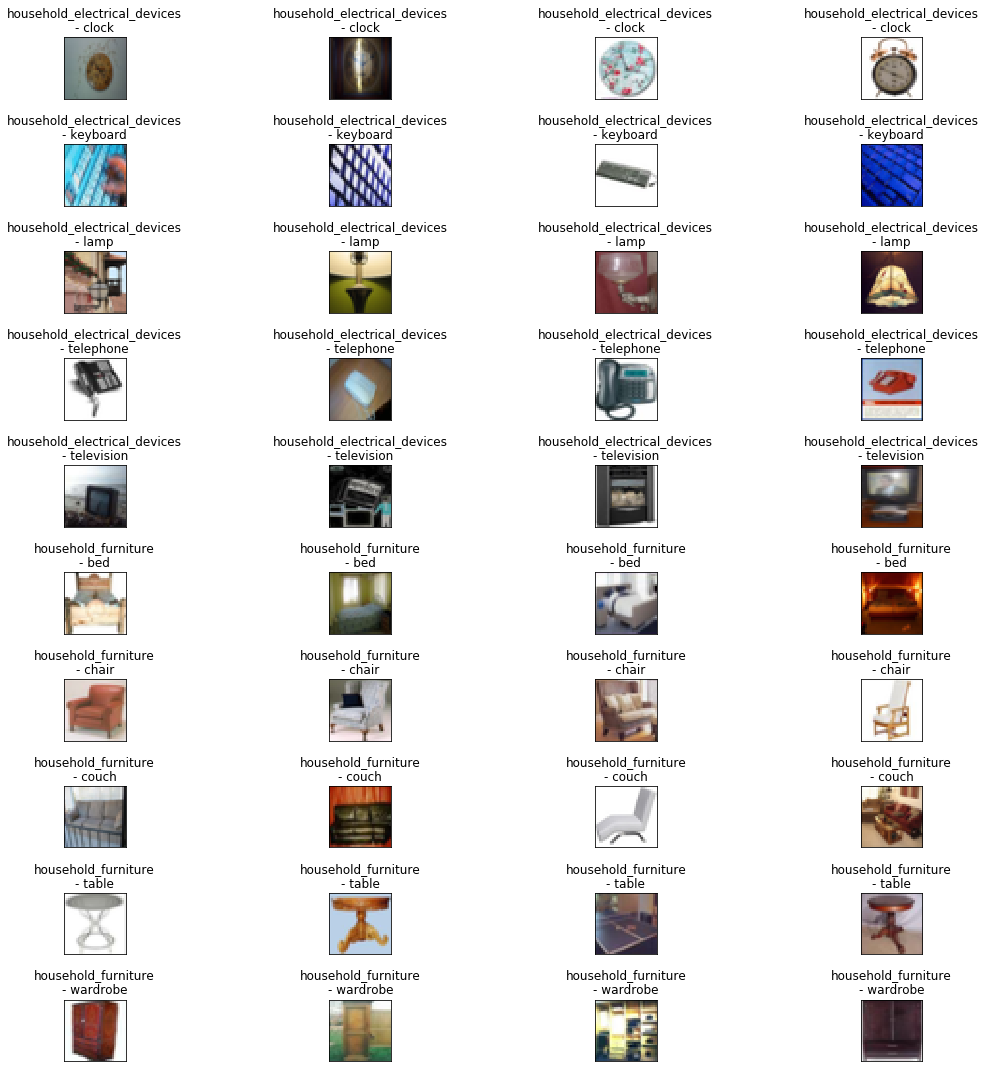

In [0]:
import matplotlib.pyplot as plt

# initialize the dict, the key is the ten fine class, the count is 0 
counts = dict.fromkeys(('clock', 'keyboard', 'lamp', 'telephone', 'television','bed', 'chair', 'couch', 'table', 'wardrobe'), 0) 

fig = plt.figure(figsize=(15, 15))

index = 0
for sample in samples:
  counts[sample.fine] += 1
  if counts[sample.fine] > 4:
    continue
  
  img = sample.data.reshape(3,32,32).transpose([1, 2, 0])
  fig.add_subplot(10, 4, index+1, xticks=[], yticks=[])
  plt.imshow(img)
  plt.title("{}\n- {}".format(sample.coarse, sample.fine))
  index += 1
      
fig.set_tight_layout(True)

<font color='blue'>Once the data is validated, we decided to save this copy of data for future purpose. Mounted Google drive again to save the preocessed data for our later work. This saved us lot of time to run many algorithms.</font>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


<font color='blue'>Saving the processed data into Google drive to take it for later purposes.</font>

In [0]:
data.repartition(4).write.parquet("/content/drive/My Drive/Project /Data Mining/Dataset/Cifar.parquet")

<font color='blue'></font>

<font color='blue'>Code to load data from drive when needed.</font>

In [0]:
data=spark.read.parquet("/content/drive/My Drive/Lsa_ml_project/1st_milestone/cifar-100-python/Parquet/*")

In [0]:
data.count()

6000

<font color='blue'>.randomSplit() is used to split train and test data. For our analysis, we have taken 80% for training and 20% for test. It splits the data randomly and the split was not balanced.</font>

In [0]:
train, test = data.randomSplit([0.8, 0.2])

In [0]:
train.count()

4853

In [0]:
test.count()

1147

### Random Forest Classifier

<font color='blue'>Random forest classifier library from pyspark.ml.NumTrees parameter is set to 200.We got the highest accuracy for Random forest algorithm with 80% accuracy.</font>

In [0]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

In [0]:
rfc=RandomForestClassifier(featuresCol="data", labelCol="labelindex",numTrees=200)

In [0]:
%%time
import time
start=time.time()
rfc_model=rfc.fit(train)
end=time.time()
print(end-start)

44.965270042419434
CPU times: user 26.1 ms, sys: 4.78 ms, total: 30.9 ms
Wall time: 45 s


<font color='blue'>Im pyspark .transform() is used to fit the data in our model.</font>

In [0]:
rfc_preds=rfc_model.transform(test)

In [0]:
type(rfc_preds)

pyspark.sql.dataframe.DataFrame

In [0]:
rfc_preds.printSchema()

root
 |-- coarse_labels: long (nullable = true)
 |-- data: vector (nullable = true)
 |-- fine_labels: long (nullable = true)
 |-- labelindex: double (nullable = false)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [0]:
rfc_preds.select('data','labelindex','prediction','probability').show()

+--------------------+----------+----------+--------------------+
|                data|labelindex|prediction|         probability|
+--------------------+----------+----------+--------------------+
|[0.00392156862745...|       0.0|       0.0|[0.75110603148279...|
|[0.00392156862745...|       0.0|       1.0|[0.49566529991853...|
|[0.00392156862745...|       0.0|       1.0|[0.41856158179937...|
|[0.00784313725490...|       0.0|       0.0|[0.62664685457068...|
|[0.01960784313725...|       0.0|       0.0|[0.67097500816988...|
|[0.02745098039215...|       0.0|       0.0|[0.55995103462329...|
|[0.03529411764705...|       0.0|       1.0|[0.46603840346522...|
|[0.03529411764705...|       0.0|       0.0|[0.64827479446369...|
|[0.03921568627450...|       0.0|       1.0|[0.42714809113596...|
|[0.05490196078431...|       0.0|       0.0|[0.65553109410272...|
|[0.05490196078431...|       0.0|       0.0|[0.59667981925300...|
|[0.05490196078431...|       0.0|       0.0|[0.70702958220601...|
|[0.058823

In [0]:
rfc_preds.count()

1147

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

<font color='blue'>BinaryClassificationEvaluator is used from pyspark.ml to calculate accuracy of the models. Random forest classifier witth 200 trees gave 80% accuracy(screenshot attached in report).</font>

In [0]:
rfc_eval=BinaryClassificationEvaluator(labelCol="labelindex")

In [0]:
print(rfc_eval.evaluate(rfc_preds))

0.7848281398233976


<font color='blue'>Classification report and confusion matrix is calculated using the prediction values.</font>

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
y_true=rfc_preds.select(['labelindex']).rdd.collect()
y_pred=rfc_preds.select(['prediction']).rdd.collect()

In [0]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.72      0.73       626
         1.0       0.71      0.72      0.71       584

    accuracy                           0.72      1210
   macro avg       0.72      0.72      0.72      1210
weighted avg       0.72      0.72      0.72      1210



In [0]:
print(confusion_matrix(y_true,y_pred))

[[451 175]
 [165 419]]


In [0]:
confusion_df = pd.DataFrame(confusion_matrix(y_true,y_pred),
             columns=["Predicted Class " + str(class_name) for class_name in ['Electronics','Furniture']],
             index = ["Class " + str(class_name) for class_name in ['Electronics','Furniture']])
print(confusion_df)

                   Predicted Class Electronics  Predicted Class Furniture
Class Electronics                          451                        175
Class Furniture                            165                        419


<font color='blue'>We have also tried to use BinaryClassificationMetrics to calculate the metrics.</font>

In [0]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [0]:
rfc_preds.printSchema()

root
 |-- coarse_labels: long (nullable = true)
 |-- data: vector (nullable = true)
 |-- fine_labels: long (nullable = true)
 |-- labelindex: double (nullable = false)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [0]:
predictionAndLabels = rfc_preds.rdd.map(lambda lp: (lp.prediction, lp.labelindex))

In [0]:
metrics = BinaryClassificationMetrics(predictionAndLabels)

In [0]:
print("Area under PR = %s" % metrics.areaUnderPR)

Area under PR = 0.6739210022600433


In [0]:
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.7189565188848528


In [0]:
conf_mat = rfc_preds.select('labelindex', 'prediction')
conf_mat.rdd.zipWithIndex().countByKey()

defaultdict(int,
            {Row(labelindex=0.0, prediction=0.0): 451,
             Row(labelindex=0.0, prediction=1.0): 175,
             Row(labelindex=1.0, prediction=0.0): 165,
             Row(labelindex=1.0, prediction=1.0): 419})

###Grid Search CV for RFC

In [0]:
rfc_cv=RandomForestClassifier(featuresCol="data", labelCol="labelindex",numTrees=200)

<font color='blue'>We have created paramaGrid to perform gridsearch CV for best model.</font>

In [0]:
from pyspark.ml.tuning import ParamGridBuilder
param_grid = ParamGridBuilder().\
    addGrid(rfc_cv.numTrees, [100, 200]).\
    build()

In [0]:
from pyspark.ml.tuning import CrossValidator
crossvalidator = CrossValidator(estimator=rfc_cv, estimatorParamMaps=param_grid, evaluator=rfc_eval)

In [0]:
crossvalidation_mode = crossvalidator.fit(train)

In [0]:
pred_train = crossvalidation_mode.transform(train)
pred_train.show(5)

+-------------+--------------------+-----------+----------+--------------------+--------------------+----------+
|coarse_labels|                data|fine_labels|labelindex|       rawPrediction|         probability|prediction|
+-------------+--------------------+-----------+----------+--------------------+--------------------+----------+
|            5|[0.0,0.0,0.0,0.0,...|         86|       0.0|[14.9325836456077...|[0.74662918228038...|       0.0|
|            5|[0.0,0.0,0.0,0.0,...|         22|       0.0|[15.1473765416434...|[0.75736882708217...|       0.0|
|            5|[0.0,0.0,0.0,0.0,...|         86|       0.0|[15.0388044229367...|[0.75194022114683...|       0.0|
|            5|[0.0,0.0,0.0,0.0,...|         40|       0.0|[11.6093594730466...|[0.58046797365233...|       0.0|
|            5|[0.0,0.0,0.0,0.0,...|         22|       0.0|[8.14010222951341...|[0.40700511147567...|       1.0|
+-------------+--------------------+-----------+----------+--------------------+----------------

In [0]:
pred_test = crossvalidation_mode.transform(test)
pred_test.show(5)

+-------------+--------------------+-----------+----------+--------------------+--------------------+----------+
|coarse_labels|                data|fine_labels|labelindex|       rawPrediction|         probability|prediction|
+-------------+--------------------+-----------+----------+--------------------+--------------------+----------+
|            5|[0.00392156862745...|         40|       0.0|[14.0610516753429...|[0.70305258376714...|       0.0|
|            5|[0.00392156862745...|         40|       0.0|[10.8996572679715...|[0.54498286339857...|       0.0|
|            5|[0.00392156862745...|         22|       0.0|[8.83446436942407...|[0.44172321847120...|       1.0|
|            5|[0.00784313725490...|         40|       0.0|[11.4557051820990...|[0.57278525910495...|       0.0|
|            5|[0.01960784313725...|         40|       0.0|[13.7413616557625...|[0.68706808278812...|       0.0|
+-------------+--------------------+-----------+----------+--------------------+----------------

# Visualizing and validating the predicted data

<font color='blue'>With the predicted output dataframe, we calculated the corse label and fine labels for each record. This is used to display in the image plot.</font>

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType
from pyspark.mllib.linalg import VectorUDT

# add two columns fine label as fine and corase label as corase,
# add the normalized data column, remove the original data column 
preds_name_df = rfc_preds.withColumn("coarse", udf(lambda coarse_label: coarse_labels[coarse_label], StringType())(target_df['coarse_labels'])) \
    .withColumn("fine", udf(lambda fine_label: fine_labels[fine_label], StringType())(target_df['fine_labels']))
    

In [0]:
preds_name_df.show()

+-------------+--------------------+-----------+----------+--------------------+--------------------+----------+--------------------+----------+
|coarse_labels|                data|fine_labels|labelindex|       rawPrediction|         probability|prediction|              coarse|      fine|
+-------------+--------------------+-----------+----------+--------------------+--------------------+----------+--------------------+----------+
|            5|[0.0,0.0,0.0,0.0,...|         86|       0.0|[115.431771876050...|[0.57715885938025...|       0.0|household_electri...| telephone|
|            5|[0.0,0.0,0.0,0.0,...|         86|       0.0|[141.976264172156...|[0.70988132086078...|       0.0|household_electri...| telephone|
|            5|[0.0,0.0,0.003921...|         40|       0.0|[112.312016988252...|[0.56156008494126...|       0.0|household_electri...|      lamp|
|            5|[0.0,0.0274509803...|         22|       0.0|[111.552097065732...|[0.55776048532866...|       0.0|household_electri.

In [0]:
# generate sample data randomly
fractions = dict()
for fine in ['clock', 'keyboard', 'lamp', 'telephone', 'television','bed', 'chair', 'couch', 'table', 'wardrobe']:
  fractions[fine] = 0.04

sample_df = preds_name_df.sampleBy('fine', fractions)
sample_df.count()

In [0]:
# generate the samples list
samples = sample_df.select('coarse', 'fine', 'data','labelindex','prediction').orderBy('coarse', 'fine').rdd.collect()

<font color='blue'>Modified the previously created function for validation to display the predicted images. Checked whether the predicted label and actual label are same or not. If not, then displayed the plot title with Red color.
</font>

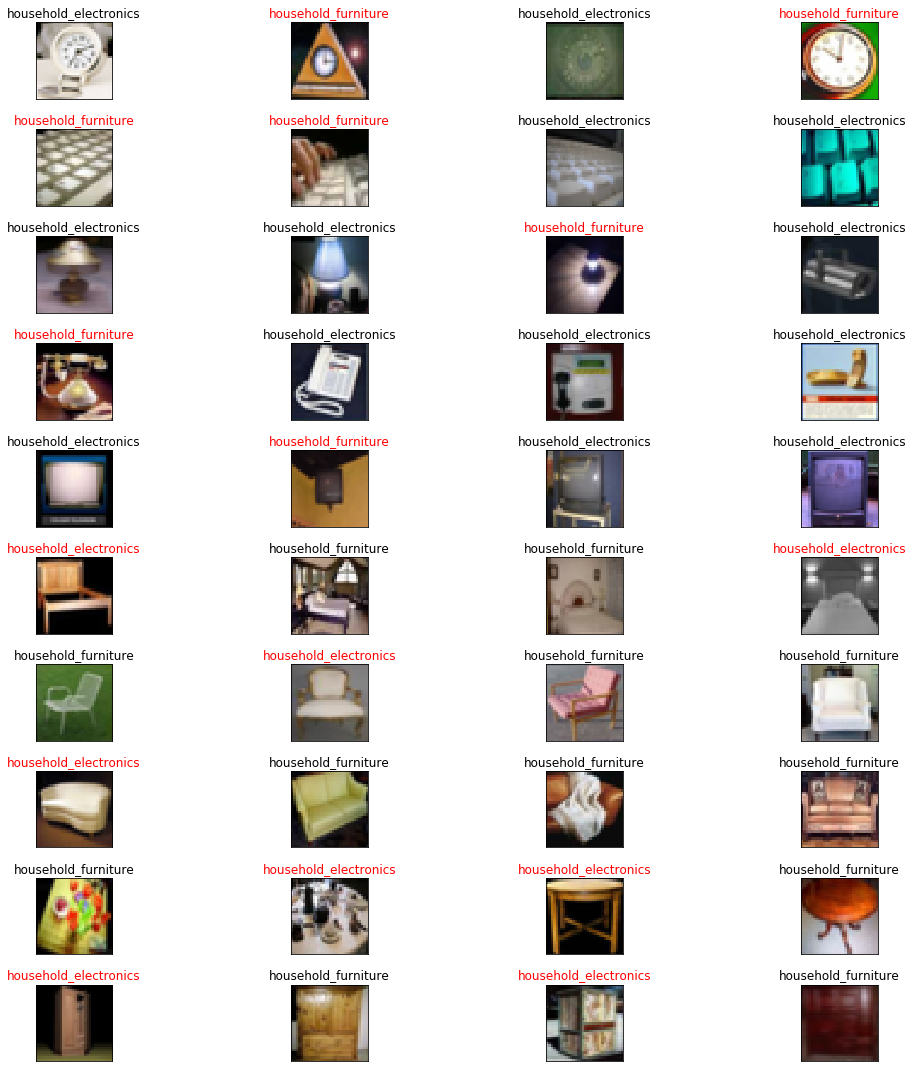

In [0]:
import matplotlib.pyplot as plt

# initialize the dict, the key is the ten fine class, the count is 0 
counts = dict.fromkeys(('clock', 'keyboard', 'lamp', 'telephone', 'television','bed', 'chair', 'couch', 'table', 'wardrobe'), 0) 

fig = plt.figure(figsize=(15, 15))

index = 0
for sample in samples_df_lr:
  counts[sample.fine] += 1
  if counts[sample.fine] > 4:
    continue
  
  img = sample.data.reshape(3,32,32).transpose([1, 2, 0])
  p_text = "household_electronics" if sample.prediction == 0.0 else "household_furniture" 
  
  fig.add_subplot(10, 4, index+1, xticks=[], yticks=[])
  plt.imshow(img)
  #plt.title("{}\n- {}".format(sample.coarse, sample.fine))
  if sample.prediction == sample.labelindex:
    plt.title("{}".format(p_text))
  else:
    plt.title("{}".format(p_text),color="red")
  index += 1
      
fig.set_tight_layout(True)

### Logistic Regression

<font color='blue'>In similar way, used logistic regression to predict the super class of the images and calculated metrics for this model. We got 66% accuracy with logistic regression.</font>

In [0]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="labelindex", featuresCol="data")



In [0]:
%%time
import time
start=time.time()
lr_model=lr.fit(train)
end=time.time()
print(end-start)

14.30902624130249
CPU times: user 36.3 ms, sys: 9.69 ms, total: 46 ms
Wall time: 14.3 s


In [0]:
lr_preds=lr_model.transform(test)

In [0]:
lr_preds.select('data','labelindex','prediction','probability').show()

+--------------------+----------+----------+--------------------+
|                data|labelindex|prediction|         probability|
+--------------------+----------+----------+--------------------+
|[0.00392156862745...|       0.0|       1.0|[0.41366120695230...|
|[0.00392156862745...|       0.0|       1.0|[0.40403993444380...|
|[0.00392156862745...|       0.0|       1.0|[0.39938836389897...|
|[0.00784313725490...|       0.0|       1.0|[0.19770898867208...|
|[0.01960784313725...|       0.0|       1.0|[0.24074477343559...|
|[0.02745098039215...|       0.0|       0.0|[0.81683794743691...|
|[0.03529411764705...|       0.0|       1.0|[0.44814190454834...|
|[0.03529411764705...|       0.0|       0.0|[0.67807122157446...|
|[0.03921568627450...|       0.0|       0.0|[0.73063627241244...|
|[0.05490196078431...|       0.0|       1.0|[0.07726326349601...|
|[0.05490196078431...|       0.0|       0.0|[0.98394772992586...|
|[0.05490196078431...|       0.0|       0.0|[0.96807774669438...|
|[0.058823

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [0]:
lr_eval=BinaryClassificationEvaluator(labelCol="labelindex")

In [0]:
print(lr_eval.evaluate(lr_preds))

0.6652253764382503


In [0]:
y_true_lr=lr_preds.select(['labelindex']).rdd.collect()
y_pred_lr=lr_preds.select(['prediction']).rdd.collect()

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
print(classification_report(y_true_lr,y_pred_lr))

              precision    recall  f1-score   support

         0.0       0.62      0.59      0.60       579
         1.0       0.60      0.63      0.61       568

    accuracy                           0.61      1147
   macro avg       0.61      0.61      0.61      1147
weighted avg       0.61      0.61      0.61      1147



In [0]:
print(confusion_matrix(y_true_lr,y_pred_lr))

[[340 239]
 [210 358]]


In [0]:
confusion_df = pd.DataFrame(confusion_matrix(y_true_lr,y_pred_lr),
             columns=["Predicted Class " + str(class_name) for class_name in ['Electronics','Furniture']],
             index = ["Class " + str(class_name) for class_name in ['Electronics','Furniture']])
print(confusion_df)

                   Predicted Class Electronics  Predicted Class Furniture
Class Electronics                          340                        239
Class Furniture                            210                        358


In [0]:
 lr_preds.show()

+-------------+--------------------+-----------+----------+--------------------+--------------------+----------+
|coarse_labels|                data|fine_labels|labelindex|       rawPrediction|         probability|prediction|
+-------------+--------------------+-----------+----------+--------------------+--------------------+----------+
|            5|[0.00392156862745...|         40|       0.0|[-0.3488504695412...|[0.41366120695230...|       1.0|
|            5|[0.00392156862745...|         40|       0.0|[-0.3886599400109...|[0.40403993444380...|       1.0|
|            5|[0.00392156862745...|         22|       0.0|[-0.4080142428853...|[0.39938836389897...|       1.0|
|            5|[0.00784313725490...|         40|       0.0|[-1.4006752037021...|[0.19770898867208...|       1.0|
|            5|[0.01960784313725...|         40|       0.0|[-1.1486006468207...|[0.24074477343559...|       1.0|
|            5|[0.02745098039215...|         39|       0.0|[1.49506943031559...|[0.8168379474369

### Naive Bayes

<font color='blue'>In similar way, used Naive bayes to predict the super class of the images and calculated metrics for this model. We got 50% accuracy with Naive bayes classification.</font>

In [0]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(featuresCol="data", labelCol="labelindex")

In [0]:
%%time
import time
start=time.time()
nb_model=nb.fit(train)
end=time.time()
print(end-start)

3.349024772644043
CPU times: user 14.1 ms, sys: 1.15 ms, total: 15.3 ms
Wall time: 3.35 s


In [0]:
nb_preds = nb_model.transform(test)
#pred.select('data','fine_labels','prediction','probability').show()

In [0]:
nb_preds.select('data','labelindex','prediction','probability').show()

+--------------------+----------+----------+--------------------+
|                data|labelindex|prediction|         probability|
+--------------------+----------+----------+--------------------+
|[0.00392156862745...|       0.0|       0.0|[0.64876572601152...|
|[0.00392156862745...|       0.0|       0.0|[0.95611925877328...|
|[0.00392156862745...|       0.0|       1.0|[1.78545866922286...|
|[0.00784313725490...|       0.0|       1.0|[0.00242817142575...|
|[0.01960784313725...|       0.0|       1.0|[0.00250949720910...|
|[0.02745098039215...|       0.0|       0.0|[0.97354678694573...|
|[0.03529411764705...|       0.0|       1.0|[2.90083419471383...|
|[0.03529411764705...|       0.0|       0.0|[0.99997283395021...|
|[0.03921568627450...|       0.0|       1.0|[0.10637815329854...|
|[0.05490196078431...|       0.0|       1.0|[0.41886156604690...|
|[0.05490196078431...|       0.0|       1.0|[0.00313746011510...|
|[0.05490196078431...|       0.0|       0.0|[0.99999999862492...|
|[0.058823

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
nb_eval=BinaryClassificationEvaluator(labelCol="labelindex")

In [0]:
print(nb_eval.evaluate(nb_preds))

0.5012162786737702


### Gradient Boosting

<font color='blue'>In similar way, used Gradient boosting to predict the super class of the images and calculated metrics for this model. We got 76% accuracy with gradient boosting. Gradient boosting took longer time fit compared to other models.</font>

In [0]:
from pyspark.ml.classification import (GBTClassifier)
from pyspark.ml import Pipeline
gbt=GBTClassifier(featuresCol="data", labelCol="labelindex")

In [0]:
%%time
import time
start=time.time()
gbt_model=gbt.fit(train)
end=time.time()
print(end-start)

378.0143709182739
CPU times: user 332 ms, sys: 50.6 ms, total: 382 ms
Wall time: 6min 18s


In [0]:
gbt_preds = gbt_model.transform(test)

In [0]:
gbt_preds.select('data','labelindex','prediction','probability').show()

+--------------------+----------+----------+--------------------+
|                data|labelindex|prediction|         probability|
+--------------------+----------+----------+--------------------+
|[0.00392156862745...|       0.0|       0.0|[0.84130165078404...|
|[0.00392156862745...|       0.0|       1.0|[0.34791561532748...|
|[0.00392156862745...|       0.0|       1.0|[0.29401580236017...|
|[0.00784313725490...|       0.0|       0.0|[0.61568442337999...|
|[0.01960784313725...|       0.0|       0.0|[0.79935208346765...|
|[0.02745098039215...|       0.0|       0.0|[0.61855817674770...|
|[0.03529411764705...|       0.0|       0.0|[0.79760264693471...|
|[0.03529411764705...|       0.0|       0.0|[0.81760187930413...|
|[0.03921568627450...|       0.0|       1.0|[0.19280153883204...|
|[0.05490196078431...|       0.0|       0.0|[0.77970426181439...|
|[0.05490196078431...|       0.0|       0.0|[0.88413759622284...|
|[0.05490196078431...|       0.0|       0.0|[0.92484728725430...|
|[0.058823

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
gbt_eval=BinaryClassificationEvaluator(labelCol="labelindex")

In [0]:
print(gbt_eval.evaluate(gbt_preds))

0.7658268262424295
